In [1]:
import pandas as pd
import numpy as np

In [2]:
bkk_fire = pd.read_csv("../../data/a1/bkk_fire.csv", parse_dates=["date"])
bkk_fire

,date,bright_t31
0,2012-01-31,293.308462
1,2012-02-29,297.839063
2,2012-03-31,296.471739
3,2012-04-30,295.727601
4,2012-05-31,293.872184
...,...,...
151,2024-08-31,292.663030
152,2024-09-30,288.234348
153,2024-10-31,294.060526
154,2024-11-30,292.558364


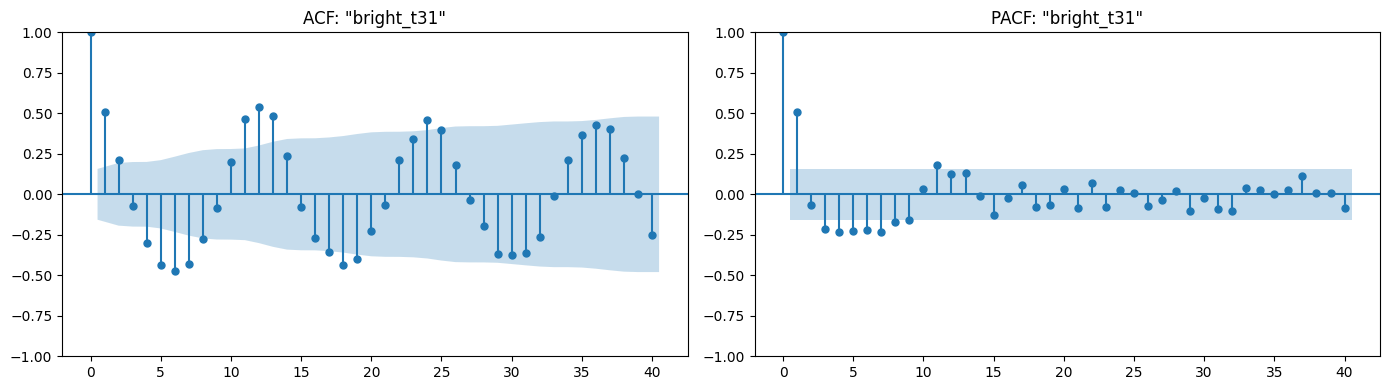

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

n_lags = 40

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF plot
plot_acf(bkk_fire["bright_t31"].dropna(), ax=axes[0], lags=n_lags)
axes[0].set_title('ACF: "bright_t31"')

# PACF plot
plot_pacf(bkk_fire["bright_t31"].dropna(), ax=axes[1], lags=n_lags, method='ywm')
axes[1].set_title('PACF: "bright_t31"')

plt.tight_layout()
plt.show()

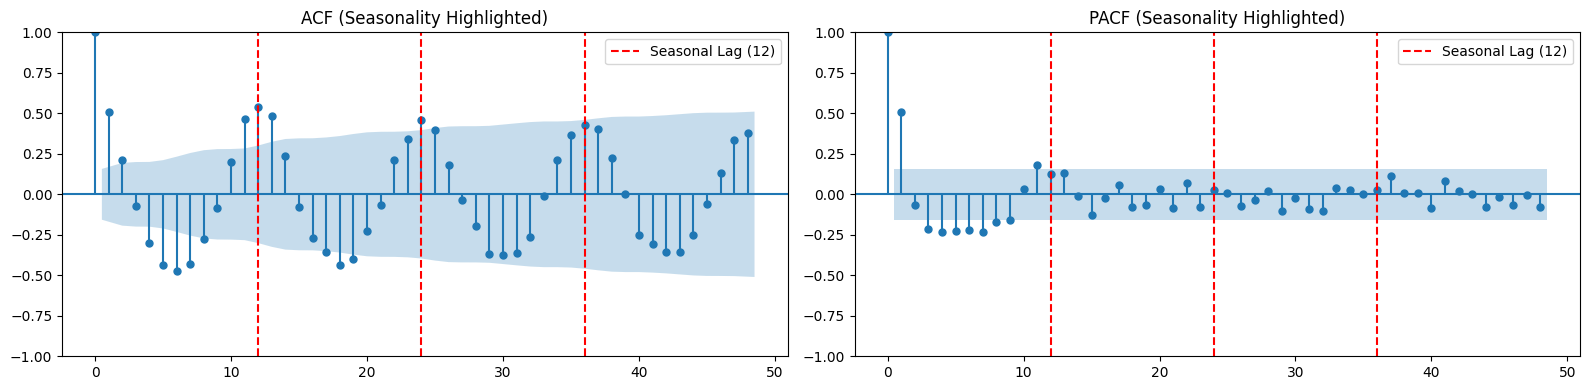

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

n_lags = 48  # Extend to show multiple seasonal cycles
seasonal_lag = 12

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(bkk_fire["bright_t31"].dropna(), ax=axes[0], lags=n_lags)
axes[0].set_title('ACF (Seasonality Highlighted)')
axes[0].axvline(seasonal_lag, color='red', linestyle='--', label='Seasonal Lag (12)')
axes[0].axvline(seasonal_lag*2, color='red', linestyle='--')
axes[0].axvline(seasonal_lag*3, color='red', linestyle='--')
axes[0].legend()

# PACF
plot_pacf(bkk_fire["bright_t31"].dropna(), ax=axes[1], lags=n_lags, method='ywm')
axes[1].set_title('PACF (Seasonality Highlighted)')
axes[1].axvline(seasonal_lag, color='red', linestyle='--', label='Seasonal Lag (12)')
axes[1].axvline(seasonal_lag*2, color='red', linestyle='--')
axes[1].axvline(seasonal_lag*3, color='red', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller

ts = bkk_fire["bright_t31"].dropna()

adf_result = adfuller(ts)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# Interpretation
if adf_result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")


ADF Statistic: -3.812222379988038
p-value: 0.0027847105759752667
Critical Value (1%): -3.4769274060112707
Critical Value (5%): -2.8819726324025625
Critical Value (10%): -2.577665408088415
The series is likely stationary.


In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop NA and ensure datetime index
y = bkk_fire["bright_t31"].dropna()
if not isinstance(y.index, pd.DatetimeIndex):
    y.index = pd.to_datetime(bkk_fire.loc[y.index, "date"])


In [7]:
# Forecast horizon
forecast_steps = 12

# Train-test split
y_train = y[:-forecast_steps]
y_test = y[-forecast_steps:]

In [8]:
# Define SARIMA order
sarima_order = (1, 0, 1)
seasonal_order = (1, 0, 1, 12)

# Fit model
model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [9]:
# Generate forecast
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Forecast index
forecast_index = pd.date_range(start=y_train.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')
forecast_mean.index = forecast_index
y_test.index = forecast_index  # Ensure alignment

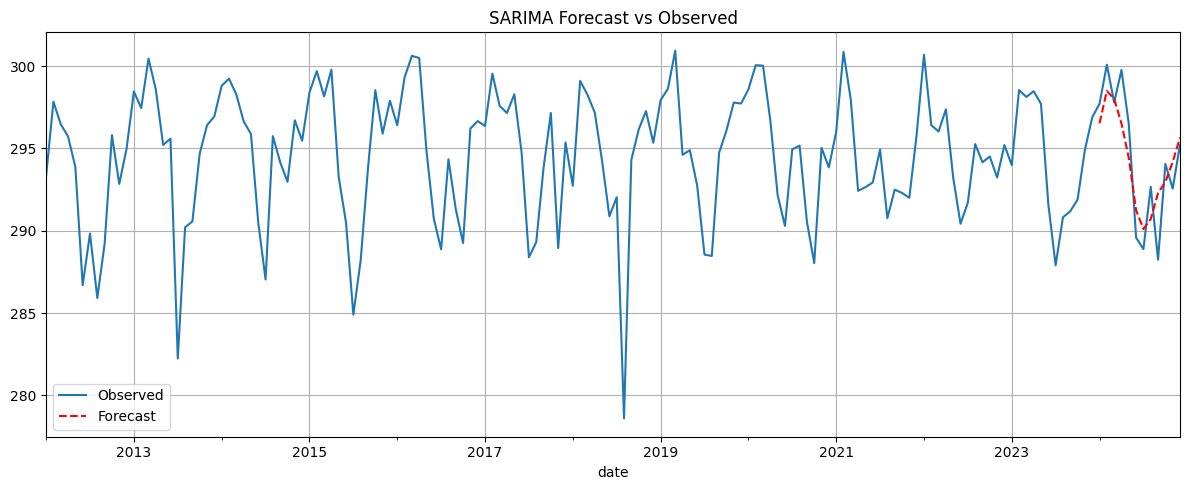

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
y.plot(ax=ax, label='Observed')
forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')
ax.set_title('SARIMA Forecast vs Observed')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
print("Forecasted values:")
print(forecast_mean)


Forecasted values:
2024-01-01    296.527634
2024-02-01    298.495400
2024-03-01    298.001687
2024-04-01    296.515401
2024-05-01    294.418716
2024-06-01    291.238212
2024-07-01    290.104348
2024-08-01    290.710417
2024-09-01    292.286179
2024-10-01    292.962572
2024-11-01    294.174330
2024-12-01    295.666299
Freq: MS, Name: predicted_mean, dtype: float64


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mape = mean_absolute_percentage_error(y_test, forecast_mean)
r2 = r2_score(y_test, forecast_mean)

print("Forecast Accuracy Metrics:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

Forecast Accuracy Metrics:
MAE  : 1.696
RMSE : 1.986
MAPE : 0.58%
R²   : 0.747


In [13]:
# Forecast horizon
forecast_steps = 12

# Generate forecast
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create index for forecast
forecast_index = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Combine into DataFrame
forecast_df = pd.DataFrame({
    "Forecast": forecast_mean,
    "Lower CI": forecast_ci.iloc[:, 0],
    "Upper CI": forecast_ci.iloc[:, 1]
})

# Show the DataFrame
forecast_df


,Forecast,Lower CI,Upper CI
2025-01-01,296.527634,291.399313,301.655955
2025-02-01,298.495400,293.348891,303.641909
2025-03-01,298.001687,292.840815,303.162558
2025-04-01,296.515401,291.342926,301.687876
2025-05-01,294.418716,289.236862,299.600570
2025-06-01,291.238212,286.048774,296.427649
2025-07-01,290.104348,284.908777,295.299920
2025-08-01,290.710417,285.509883,295.910951
2025-09-01,292.286179,287.081629,297.490729
2025-10-01,292.962572,287.754772,298.170372


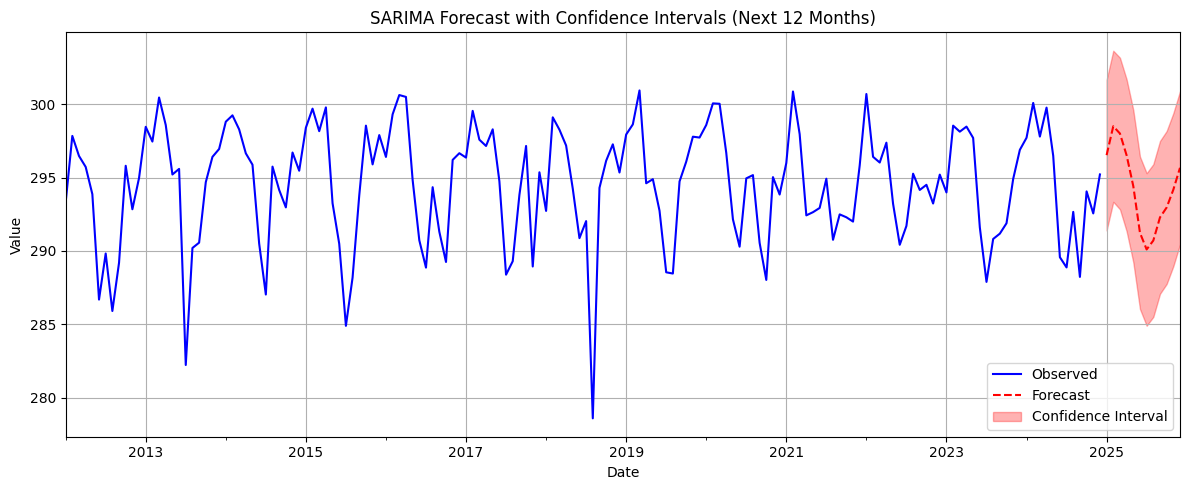

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))

y.plot(ax=ax, label='Observed', color='blue')

forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')

ax.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                color='red', alpha=0.3, label='Confidence Interval')

ax.set_title('SARIMA Forecast with Confidence Intervals (Next 12 Months)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
df = forecast_df["Forecast"]
df = df.rename("bright_t31")
df.to_csv("../../data/a1/bkk_fire_forecast.csv", index=True)